# Generating nodule images with Denoising Diffusion Model

## Training of DDPM on LIDC data.

Model is trained on nodule CT scans previously extracted from LIDC repository. Training images are of shape (1, 32, 32) and pixel values are scaled to the range [0, 1]

In [1]:
from DDPM_model import DDPM_model
from LIDC_Dataset import LIDC_Dataset
from torch.utils.data import DataLoader
from pathlib import Path
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
import torch

In [3]:
def train_DDPM(n_epoch, batch_size, n_T, device, n_feat, lrate, model_name):
    
    # General settings:
    n_classes = 2 # in the LIDC dataset there are only two classes: beningn and malignant
    save_model_structure = True # saving structure and weights
    save_weights_only = False # saving only weights
    ws_test = [0.5, 1.0, 1.5, 2.0] # strength of generative guidance

    # Path settings:
    plot_path = f"./plots/{model_name}/"
    model_path = "./saved_model/"
    Path(plot_path).mkdir(parents=True, exist_ok=True)
    Path(model_path).mkdir(parents=True, exist_ok=True)

    # Creating model instance:
    ddpm = DDPM_model(n_feat=320, n_T=400, device="cuda")
    ddpm.to(device)

    # Preparing dataset, dataloader, optimizer:
    dataset = LIDC_Dataset("/home/dzban112/LIDC_repo/dataset", train_mode=True)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    optim = torch.optim.Adam(ddpm.parameters(), lr=lrate)

    for ep in range(n_epoch):
        print(f'epoch {ep}')
        ddpm.train()

        # linear lrate decay
        optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

        pbar = tqdm(dataloader)
        loss_ema = None
        for x, c in pbar: # x is a batch of images, c is a corresponding context (label set)
            optim.zero_grad()
            x = x.to(device)
            c = c.to(device)
            loss = ddpm(x, c)
            loss.backward()
            if loss_ema is None: # Exponential moving average of loss is used to monitor loss across batches.
                loss_ema = loss.item()
            else:
                loss_ema = 0.95 * loss_ema + 0.05 * loss.item()
            pbar.set_description(f"loss: {loss_ema:.4f}")
            optim.step()
        
        if(ep%5 == 0 or ep == int(n_epoch-1)): 
            # for evaluation, save an image of currently generated samples (top 8 rows)
            # followed by real images (bottom 8 rows)
            ddpm.eval()
            with torch.no_grad():
                n_sample = 8*n_classes
                
                for w in ws_test:
                    x_gen, _, x_gen_store = ddpm.sample(n_sample, (1, 32, 32), device, guide_w=w)
                    # append some real images at bottom, order by class also
                    x_real = torch.Tensor(x_gen.shape).to(device)
                    for k in range(n_classes):
                        for j in range(int(n_sample/n_classes)):
                            try: 
                                idx = torch.squeeze((c == k).nonzero())[j]
                            except:
                                idx = 0
                            x_real[k+(j*n_classes)] = x[idx]

                    x_all = torch.cat([1-x_gen, 1-x_real])
                    grid = make_grid(x_all*-1 + 1, nrow=2)
                    save_image(grid, plot_path + f"image_ep{ep}_w{w}.png")
                    print('saved image at ' + plot_path + f"image_ep{ep}_w{w}.png")

        if save_model_structure and ep == int(n_epoch-1):
            torch.save(ddpm, model_path + f"{model_name}_{ep}.pth")
            print('saved model at ' + model_path + f"{model_name}_{ep}.pth")
        elif save_weights_only and ep == int(n_epoch-1):
            torch.save(ddpm.state_dict(), model_path + f"{model_name}_{ep}.pth")
            print('saved model at ' + model_path + f"{model_name}_{ep}.pth")

In [14]:
train_DDPM(n_epoch=18, batch_size=32, n_T=500, device="cuda", n_feat=256, lrate=1e-4, model_name="model_256")

epoch 0


loss: 0.4058: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.15it/s]



saved image at ./plots/model_256/image_ep0_w0.5.png

saved image at ./plots/model_256/image_ep0_w1.0.png

saved image at ./plots/model_256/image_ep0_w1.5.png

saved image at ./plots/model_256/image_ep0_w2.0.png
epoch 1


loss: 0.0901: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.52it/s]


epoch 2


loss: 0.0615: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.51it/s]


epoch 3


loss: 0.0632: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.34it/s]


epoch 4


loss: 0.0592: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.40it/s]


epoch 5


loss: 0.0444: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.39it/s]



saved image at ./plots/model_256/image_ep5_w0.5.png

saved image at ./plots/model_256/image_ep5_w1.0.png

saved image at ./plots/model_256/image_ep5_w1.5.png

saved image at ./plots/model_256/image_ep5_w2.0.png
epoch 6


loss: 0.0563: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.29it/s]


epoch 7


loss: 0.0451: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.26it/s]


epoch 8


loss: 0.0406: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.38it/s]


epoch 9


loss: 0.0421: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.18it/s]


epoch 10


loss: 0.0406: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.40it/s]



saved image at ./plots/model_256/image_ep10_w0.5.png

saved image at ./plots/model_256/image_ep10_w1.0.png

saved image at ./plots/model_256/image_ep10_w1.5.png

saved image at ./plots/model_256/image_ep10_w2.0.png
epoch 11


loss: 0.0360: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.41it/s]


epoch 12


loss: 0.0416: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.33it/s]


epoch 13


loss: 0.0346: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.26it/s]


epoch 14


loss: 0.0329: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.18it/s]


epoch 15


loss: 0.0340: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.31it/s]



saved image at ./plots/model_256/image_ep15_w0.5.png

saved image at ./plots/model_256/image_ep15_w1.0.png

saved image at ./plots/model_256/image_ep15_w1.5.png

saved image at ./plots/model_256/image_ep15_w2.0.png
epoch 16


loss: 0.0457: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.25it/s]


epoch 17


loss: 0.0379: 100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 10.26it/s]



saved image at ./plots/model_256/image_ep17_w0.5.png

saved image at ./plots/model_256/image_ep17_w1.0.png

saved image at ./plots/model_256/image_ep17_w1.5.png

saved image at ./plots/model_256/image_ep17_w2.0.png
saved model at ./saved_model/model_256_17.pth


## Generating images with trained model

In [2]:
import torch
import matplotlib.pyplot as plt

In [8]:
def plot_grid(x_gen, n_sample, c):
    assert n_sample%2==0, "n_sample should be odd!"
    plt.set_cmap('gray')
    fig, axes = plt.subplots(2, int(n_sample/2), figsize=(15, 5))
    k=0
    for i in range(axes.shape[0]):
        for j in range(n_sample//2):
            img = x_gen[k][0].cpu()
            axes[i][j].imshow(img)
            axes[i][j].set_title(f"Class: {c[k]}")
            k+=1


def plot_image(path2imgs, img_name, grid=True):
    plt.set_cmap('gray')         
    img = torch.load(f"{path2imgs}/{img_name}").cpu()[0]
    plt.imshow(img)
    plt.show()


def generate(n_sample, guide_w, path_to_model, test_gen=True):
    device = torch.device("cuda")
    ddpm = torch.load(path_to_model)
    ddpm = ddpm.to(device)   
    ddpm.eval()
    
    with torch.no_grad():
        x_gen, c, x_gen_store = ddpm.sample(n_sample, (1, 32, 32), device, guide_w=guide_w)
    if test_gen:
        plot_grid(x_gen, n_sample, c)
    else:
        return x_gen, c, x_gen_store 


def save_gen_imgs(n_sample, guide_w, model_name):
    path_to_model = f"./saved_model/{model_name}.pth"
    class_0_storage_folder = f"./gen_imgs/{model_name}/class0/"
    class_1_storage_folder = f"./gen_imgs/{model_name}/class1/"
    Path(class_0_storage_folder).mkdir(parents=True, exist_ok=True)
    Path(class_1_storage_folder).mkdir(parents=True, exist_ok=True)

    x_gen, c, _ = generate(n_sample, guide_w, path_to_model, test_gen=False)
    assert x_gen.shape[0] == c.shape[0], "Unconsistent shapes!"
    for i in range(x_gen.shape[0]):
        if c[i] == 0:
            save_path = class_0_storage_folder
        elif c[i] == 1:
            save_path = class_1_storage_folder
        img = x_gen[i]
        id = str(i+1).zfill(4)
        torch.save(img.clone(), f"{save_path}/{id}.pt")
    print("")
    print("Images saved :D")

## Trial generation

<Figure size 640x480 with 0 Axes>

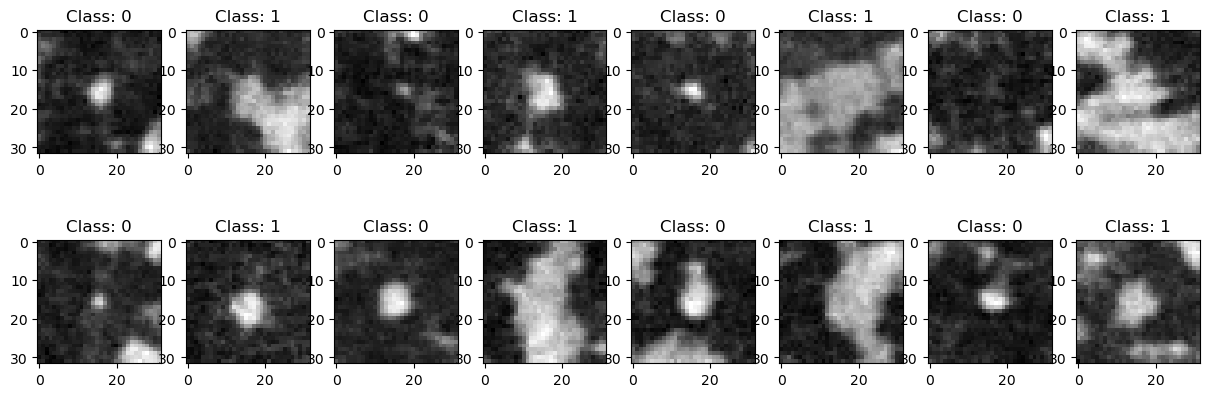

In [12]:
# Model 256 features in the latent space, n_T=500:
generate(n_sample=16, guide_w=1.75, path_to_model="./saved_model/model_256_17.pth", test_gen=True)

## Generation and saving images

In [13]:
n_sample = 400 #How many images to generate.
guide_w = 1.7 #Strength of generative guidance.
model_name = "model_256_17"

save_gen_imgs(n_sample=n_sample, guide_w=guide_w, model_name=model_name)


sampling timestep 100
Images saved :D
